# Data Analysis 7 (DTA V2.0r1)

## Details:
> - trading time has changed to 9:00-16:00
> - 840 -> 420
> - add some features

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_tools as dt
import data_utils as du

# Section 1: Load data

In [3]:
def load_data(filepath):
    """
    Load data to pd.DataFrame, drop days which contains irregular data.
    Return dataframe, metric_name and date_list 
    """
    metric_name = filepath.split('_')[-1][:3]
    data = pd.read_csv(filepath, index_col=0)
    # +8 hours for beijing time
    data.index = pd.to_datetime(data.index, unit='s') + pd.Timedelta('8 hours')
    date_list = sorted({i.strftime("%Y-%m-%d") for i in data.index})
    i = 0
    while i < len(date_list):
        if data.loc[date_list[i]].shape[0] != 840:
            date_list.pop(i)
        i += 1
    print 'metric:', metric_name
    print 'from '+ date_list[0] + ' to ' + date_list[-1] + ': ' + str(len(date_list)) +' days.'
    print date_list
    print "===="*34
    return pd.concat(data[i] for i in date_list), date_list

In [4]:
cpu_data_raw, date_list = load_data('../data/tradetime_cpu(1).csv')
rps_data_raw, _ = load_data('../data/tradetime_rps(1).csv')

metric: cpu
from 2017-06-12 to 2017-10-16: 84 days.
['2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-18', '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31', '2017-09-01', '2017-09-04', '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-

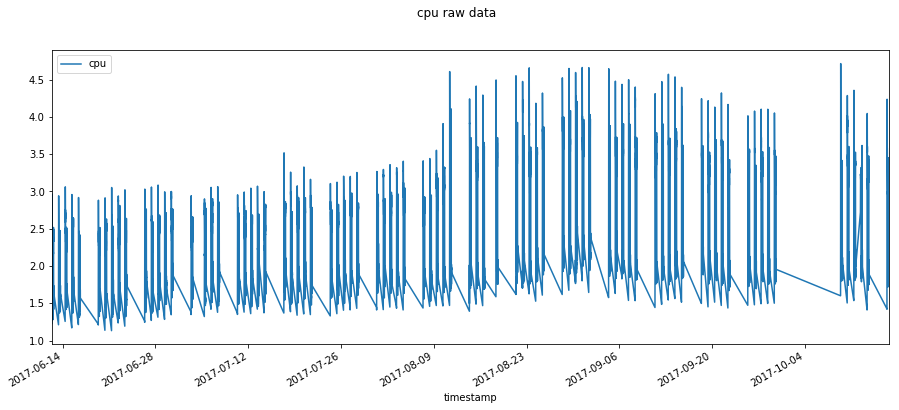

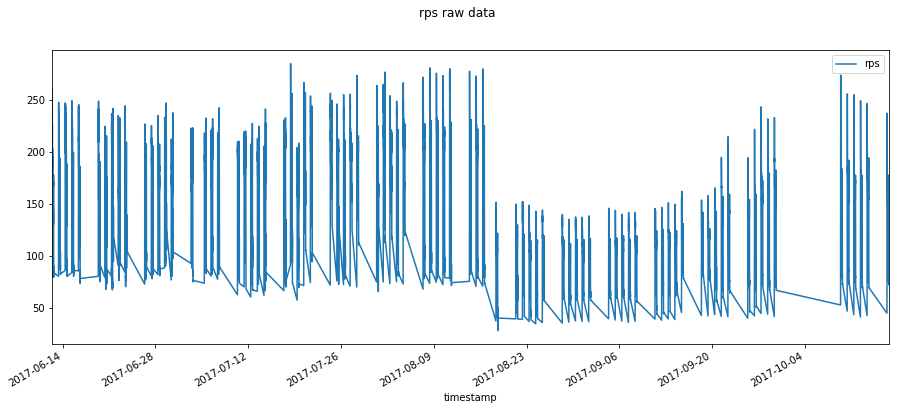

In [5]:
cpu_data_raw.plot(figsize=(15, 6), subplots=True, title='cpu raw data')
rps_data_raw.plot(figsize=(15, 6), subplots=True, title='rps raw data')
plt.show()

# Section 2: Calculate mu and sigma

In [6]:
ppd = 840
days = cpu_data_raw.size / ppd
days

84

In [163]:
cpu_data = np.reshape(cpu_data_raw.values, (days, ppd))
rps_data = np.reshape(rps_data_raw.values, (days, ppd))

In [164]:
cpu_data = cpu_data[:, ::2]
rps_data = rps_data[:, ::2]

In [165]:
cpu_mu = cpu_data.mean(axis=0)
cpu_sigma = cpu_data.std(axis=0)

rps_mu = rps_data.mean(axis=0)
rps_sigma = rps_data.std(axis=0)

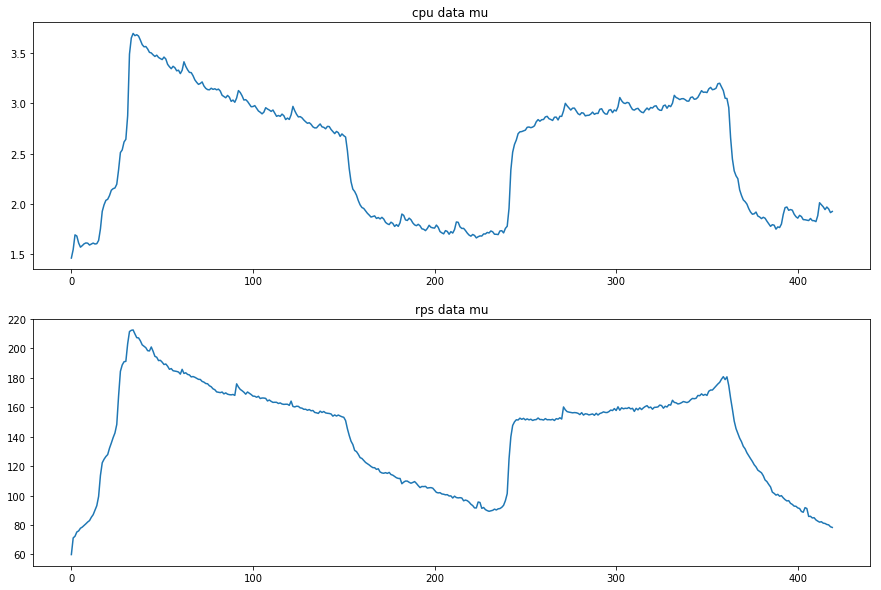

In [166]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(cpu_mu)
plt.title('cpu data mu ')
plt.subplot(212)
plt.plot(rps_mu)
plt.title('rps data mu')
plt.show()

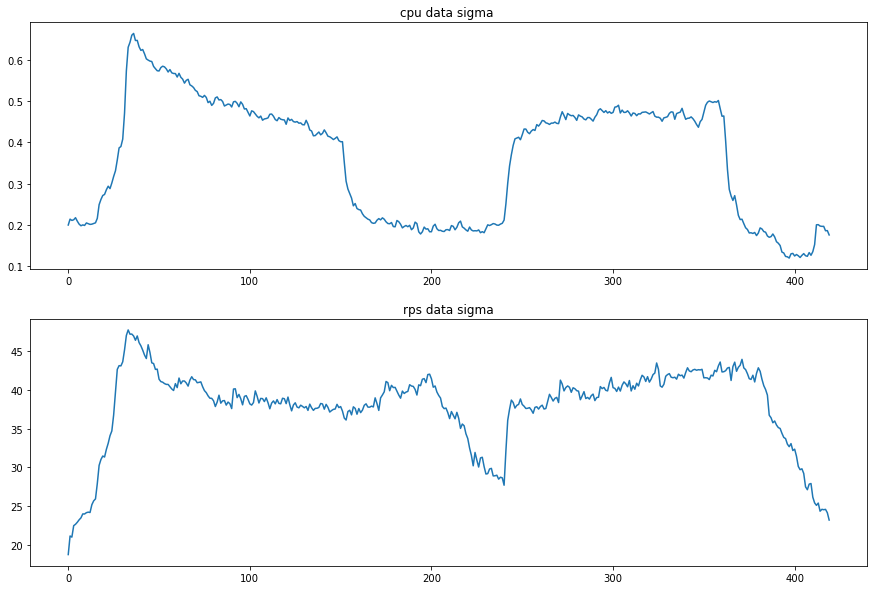

In [167]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(cpu_sigma)
plt.title('cpu data sigma ')
plt.subplot(212)
plt.plot(rps_sigma)
plt.title('rps data sigma')
plt.show()

# Section 3: Choose base_data 

In [11]:
def kNN(X, mu, n=5):
    """
    Return base_data
    n is length of base_data, default is 5
    """
    dist = ((X - mu)**2).sum(axis=1)
    idx_n = np.argsort(dist)[:n]
    return X[idx_n]

In [168]:
cpu_base_data = kNN(cpu_data, cpu_mu, n = 5)
rps_base_data = kNN(rps_data, rps_mu, n = 5)

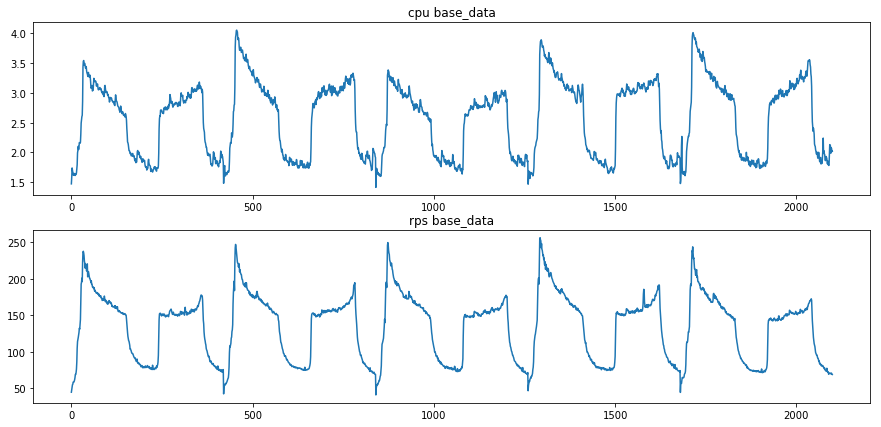

In [169]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(cpu_base_data.ravel())
plt.title('cpu base_data')
plt.subplot(212)
plt.plot(rps_base_data.ravel())
plt.title('rps base_data')
plt.show()

In [170]:
# correct rps_sigma
rps_sigma = rps_data[-30:].std(axis=0)

# Section 4: Calculate baseline, upper_thresh, lower_thresh

In [171]:
cpu_test_data = cpu_data[-5:]
rps_test_data = rps_data[-5:]

In [16]:
from random import randrange

In [178]:
# random choose test set
i = randrange(1, 5)
# Use the base_data to polyfit the last day data
cpu_p = np.polyfit(cpu_base_data.mean(axis=0), cpu_test_data[i-1], 1)
rps_p = np.polyfit(rps_base_data.mean(axis=0), rps_test_data[i-1], 1)

# set k
k1 = 1
k2 = 1

# calculate baseline, upper_thresh and lower_thresh
cpu_baseline = du.smooth_moving(cpu_base_data.mean(axis=0))
cpu_baseline = cpu_baseline*cpu_p[0] + cpu_p[1]
cpu_upper_thresh = du.smooth_moving(cpu_baseline + k1*cpu_sigma)
cpu_lower_thresh = du.smooth_moving(cpu_baseline - k2*cpu_sigma)

rps_baseline = du.smooth_moving(rps_base_data.mean(axis=0))
rps_baseline = rps_baseline*rps_p[0] + rps_p[1]
rps_upper_thresh = du.smooth_moving(rps_baseline + k1*rps_sigma)
rps_lower_thresh = du.smooth_moving(rps_baseline - k2*rps_sigma)

# find anomalies
cpu_idx = np.where(np.any([cpu_test_data[i]>cpu_upper_thresh, cpu_test_data[i]<cpu_lower_thresh], axis=0))
rps_idx = np.where(np.any([rps_test_data[i]>rps_upper_thresh, rps_test_data[i]<rps_lower_thresh], axis=0))

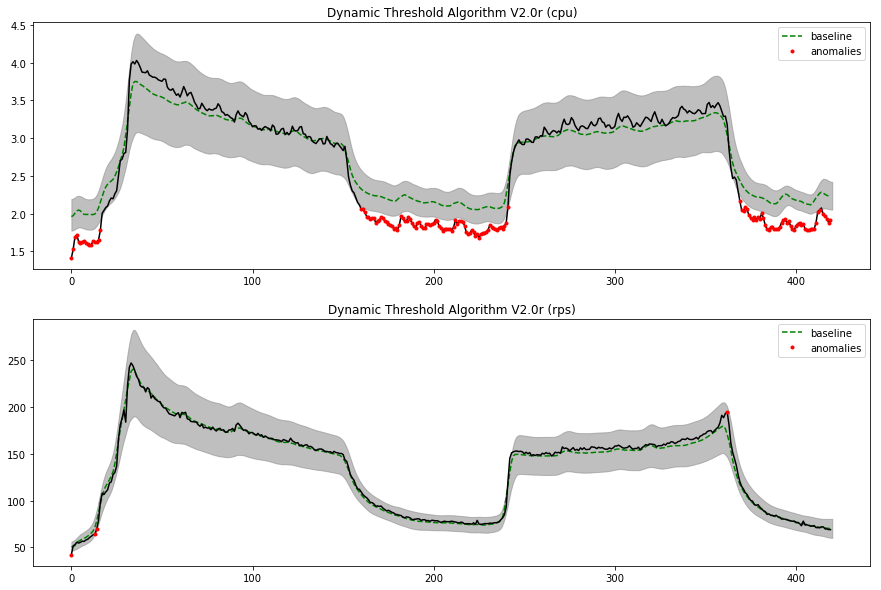

In [179]:
t = np.linspace(0, 420, 420)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(cpu_baseline, 'g--', label='baseline')
# plt.plot(cpu_upper_thresh, 'r')
# plt.plot(cpu_lower_thresh, 'r')
plt.fill_between(t, cpu_lower_thresh, cpu_upper_thresh, color=[0.5, 0.5, 0.5, 0.5])
plt.plot(cpu_test_data[i], 'k')
plt.plot(cpu_idx[0], cpu_test_data[i][cpu_idx], 'r.', label='anomalies')
plt.title('Dynamic Threshold Algorithm V2.0r (cpu)')
plt.legend()
plt.subplot(212)
plt.plot(rps_baseline, 'g--', label='baseline')
# plt.plot(rps_upper_thresh, 'r')
# plt.plot(rps_lower_thresh, 'r')
plt.fill_between(t, rps_lower_thresh, rps_upper_thresh, color=[0.5, 0.5, 0.5, 0.5])
plt.plot(rps_test_data[i], 'k')
plt.plot(rps_idx[0],rps_test_data[i][rps_idx], 'r.', label='anomalies')
plt.title('Dynamic Threshold Algorithm V2.0r (rps)')
plt.legend()
# save figure
# plt.savefig('Dynamic Threshold Algorithm V2.0r.png', dpi=500)
plt.show()

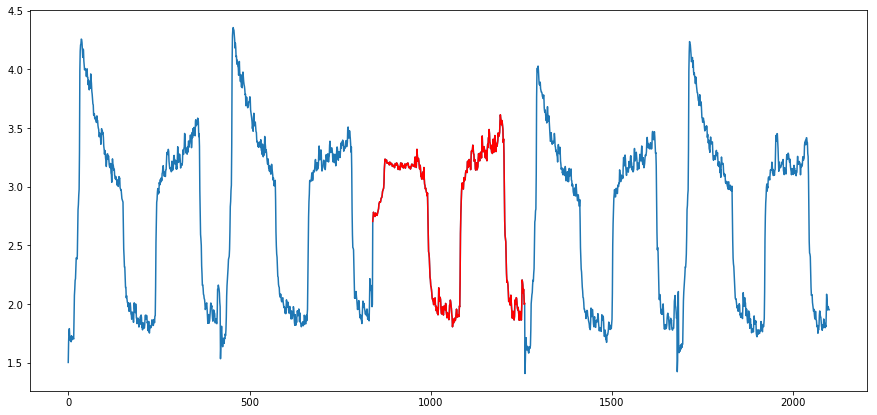

In [188]:
plt.figure(figsize=(15, 7))
plt.plot(cpu_test_data.ravel())
plt.plot(np.arange(840,1260), cpu_test_data[2], 'r')
plt.show()

# Section 5: Save model

In [19]:
import pickle

In [241]:
cpu_model = dict(base_data=cpu_base_data, sigma=cpu_sigma)
rps_model = dict(base_data=rps_base_data, sigma=rps_sigma)

In [242]:
# save model
with open('cpu_model_new.pkl', 'wb') as f:
    pickle.dump(cpu_model, f)
with open('rps_model_new.pkl', 'wb') as f:
    pickle.dump(rps_model, f)

# Section 6: Define Class

In [430]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from smooth import smooth_moving

class DTA(object):
    """
    Dynamic Threshold Algorithm Class
    ppd = 420
    """
    def __init__(self, k=(1, 1), model_path='model.pkl'):
        self._update_times = 0
        self.k1 = k[0]
        self.k2 = k[1]
        self._ppd = 420
        self.model_path = model_path
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        self.base_data = self.model['base_data']
        self.sigma = self.model['sigma']
        self.lines = dict(baseline=np.array([]), upper_thresh=np.array([]), lower_thresh=np.array([]))
        print self
    
    def __repr__(self):
        return "Dynamic Threshold Algorithm"+'('+'k1='+str(self.k1)+', k2='+str(self.k2)+')'

    def kNN(X, mu, n=5):
        """
        Return base_data
        n is length of base_data, default is 5
        """
        dist = ((X - mu)**2).sum(axis=1)
        idx_n = np.argsort(dist)[:n]
        return idx_n

    def get_params(self):
        return dict(k1=self.k1, k2=self.k2)
    
    def set_params(self, k1, k2):
        if k1 <= 0 or k2 <=0:
            raise ValueError ("k1, k2 must be > 0")
        else:
            self.k1 = k1
            self.k2 = k2

    def get_model(self):
        return dict(base_data=self.base_data, sigma=self.sigma)
    
    def set_model(self, model):
        self.base_data = model['base_data']
        self.sigma = model['sigma']

    def calulate(self, refer_data, smooth_window_len=5):
        baseline = smooth_moving(self.base_data.mean(axis=0), window_len=smooth_window_len)
        if (np.isnan(refer_data)).sum() < refer_data.size / 10:
            self.p = np.polyfit(self.base_data.mean(axis=0), np.nan_to_num(refer_data), 1)
            baseline = baseline*self.p[0] + self.p[1]
        upper_thresh = smooth_moving(baseline + self.k1*self.sigma, window_len=smooth_window_len)
        lower_thresh = smooth_moving(baseline - self.k2*self.sigma, window_len=smooth_window_len)
        self.lines = dict(baseline=baseline, upper_thresh=upper_thresh, lower_thresh=lower_thresh)
        print "Lines Calculated"
    
    def update_model(self, new_data, update_base_data=True, update_sigma=False):
        if self._update_times == 1:
            print "You have already updated!"
            return
        if new_data.ndim == 1:
            new_data = new_data.reshape(1, new_data.size)
        mu = self.base_data.mean(axis=0)
        if update_base_data:
            concat_data = np.concatenate((self.base_data, new_data), axis=0)
            idx = kNN(concat_data, mu)
            if 5 in idx:
                self.base_data = concat_data[idx]
                for path, dirs, files in os.walk('.'):
                    if self.model_path in files:
                        if self.model_path+'.bak' in files:
                            os.remove(self.model_path+'.bak')
                        os.rename(path+'\\'+self.model_path, path+'\\'+self.model_path+'.bak')
                with open(self.model_path, 'wb') as f:
                    self.model['base_data'] = self.base_data
                    pickle.dump(self.model, f)
                print "Update complete!"
            else:
                print "No need to update!"
        if update_sigma:
            self.sigma = (1-0.1)*self.sigma + 0.1*(((refer_data-mu)**2).sum(axis=1))**0.5
            for path, dirs, files in os.walk('.'):
                if self.model_path in files:
                    if self.model_path+'.bak' in files:
                        os.remove(self.model_path+'.bak')
                    os.rename(path+'\\'+self.model_path, path+'\\'+self.model_path+'.bak')
            with open(self.model_path, 'wb') as f:
                self.model['sigma'] = self.sigma
                pickle.dump(self.model, f)
        self._update_times += 1
    
    def draw_lines(self, test_data=False, anomaly_on=False, figsize=(15, 7)):
        if test_data.ndim == 2:
            test_data = test_data.ravel()
        if self.lines['baseline'].shape[0] == 0:
            print "Lines haven't been calculated!"
            return
        idx = np.where(np.any([test_data>self.lines['upper_thresh'], test_data<self.lines['lower_thresh']], axis=0))
        t = np.linspace(0, self._ppd, self._ppd)
        plt.figure(figsize=figsize)
        plt.plot(self.lines['baseline'], 'g--', label='baseline')
        plt.fill_between(t, self.lines['lower_thresh'], self.lines['upper_thresh'], color=[0.5, 0.5, 0.5, 0.5])
        if np.all(test_data):
            plt.plot(test_data, 'k', label='test data')
            if anomaly_on:
                plt.plot(idx[0], test_data[idx], 'ro', label='anomalies')
        plt.legend()
        plt.title('Dynamic Threshold : k1={0}, k2={1}, anomaly num={2}'.format(self.k1, self.k2, idx[0].size))
        plt.show()
    

# Section 7: Test DTA class

### cpu

In [450]:
i = randrange(1, 5)
the_last_day_data = cpu_test_data[i-1]
today_data = cpu_test_data[i]

In [451]:
A = DTA(model_path='cpu_model_new.pkl')

Dynamic Threshold Algorithm(k1=1, k2=1)


In [421]:
A.set_params(1, 1)

In [422]:
A.get_params()

{'k1': 1, 'k2': 1}

In [452]:
A.calulate(the_last_day_data)

Lines Calculated


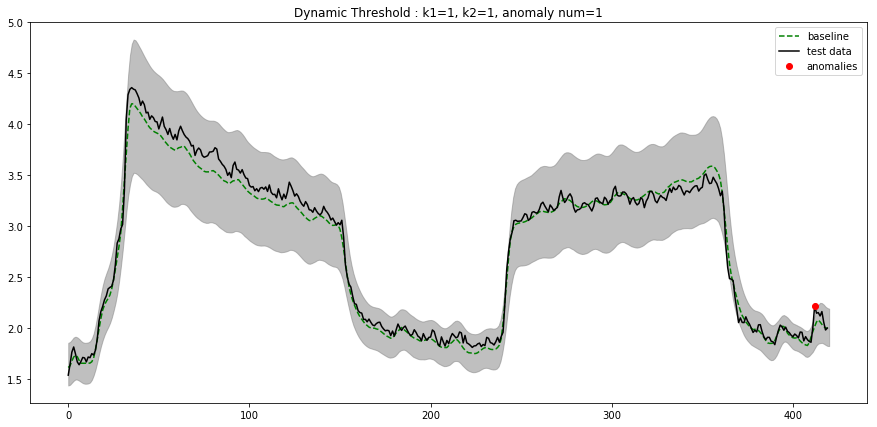

In [453]:
A.draw_lines(today_data, anomaly_on=True)

In [441]:
A.update_model(the_last_day_data)

No need to update!


### rps

In [442]:
i = randrange(1, 5)
the_last_day_data = rps_test_data[i-1]
today_data = rps_test_data[i]

In [443]:
B = DTA((2,3), model_path='rps_model_new.pkl')

Dynamic Threshold Algorithm(k1=2, k2=3)


In [446]:
B.set_params(1, 1)

In [447]:
B.get_params()

{'k1': 1, 'k2': 1}

In [448]:
B.calulate(the_last_day_data)

Lines Calculated


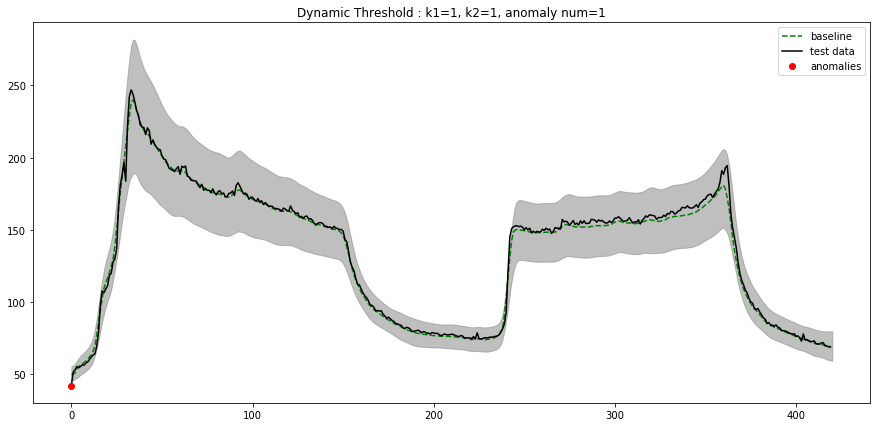

In [449]:
B.draw_lines(today_data, anomaly_on=True)

In [390]:
B.update_model(the_last_day_data)

No need to update!
